# Initialize

## ASW session

In [1]:
import boto3

session = boto3.Session()
s3 = session.resource('s3')

## SageMaker Session

In [2]:
import sagemaker

sage_session = sagemaker.Session()

# Define Globals

In [3]:
# bucket name
bucket = 'aida-project'

# path for s3_input
s3_path = f"s3://{bucket}/"

## define source files
# TRAIN source file
train_source_path = 'team_remote'
train_source_name = 'title-train.csv'
#train_source_name = 'title-valid.csv'       # for testing; remove later


# VALID source file
valid_source_path = 'team_remote'
valid_source_name = 'title-valid.csv'
#valid_source_name = 'title-test.csv'       # for testing; remove later

# TEST source file
test_source_path = 'team_remote'
test_source_name = 'title-test.csv'

# output for result
output_path ='team_remote'
output_location = f'{s3_path}{output_path}/output'

In [4]:
print(output_location)

s3://aida-project/team_remote/output


In [5]:
# Create pointers to the S3 train and test datasets

from sagemaker import s3_input

# print(f"{s3_path}{train_source_path}/{train_source_name}")
# print(f"{s3_path}{valid_source_path}/{valid_source_name}")
# print(f"{s3_path}{test_source_path}/{test_source_name}")
s3_input_train = sagemaker.session.s3_input(s3_data=f"{s3_path}{train_source_path}/{train_source_name}", content_type="text/csv")
s3_input_valid = sagemaker.session.s3_input(s3_data=f"{s3_path}{valid_source_path}/{valid_source_name}", content_type="text/csv")
s3_input_test = sagemaker.session.s3_input(s3_data=f"{s3_path}{test_source_path}/{test_source_name}", content_type="text/csv")

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [6]:
role = sagemaker.get_execution_role()

# Define Model

In [7]:
# finde pre-defined models here:
# https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html

# Create an XGBoost Estimator

# estimator call
# <ecr_path>/sagemaker-xgboost:1.2-1
    
ecr_path = "492215442770.dkr.ecr.eu-central-1.amazonaws.com"
xgboost_estimator = f"{ecr_path}/sagemaker-xgboost:1.0-1-cpu-py3"

# ecr_path = "664544806723.dkr.ecr.eu-central-1.amazonaws.com"
# knn_estimator = f"{ecr_path}/knn:latest"


In [8]:
xgboost = sagemaker.estimator.Estimator(xgboost_estimator,
                              role,
                              train_instance_count=1,
                              train_instance_type="ml.m5.4xlarge",
                              output_path=output_location,
                              sagemaker_session=sage_session,
                              base_job_name="JPC-xgboost")

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [9]:
# Select the your specific hyperparameters (Optional)
# https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html
# https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst#learning-task-parameters 

xgboost.set_hyperparameters(
    eta=.35,
    num_round=50,                     # required parameter!
    objective = 'reg:linear',
    )

In [119]:
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig, CollectionConfig
from sagemaker.estimator import Estimator 
save_interval = 10
xgboost_debugger = Estimator( role=role, 
                             base_job_name="JPC-xgboost-debug", 
                             train_instance_count=1, 
                             train_instance_type='ml.m5.4xlarge', 
                             image_name=xgboost_estimator, 
                             #hyperparameters=hyperparameters, 
                             train_max_run=1800, 
                             debugger_hook_config=DebuggerHookConfig( s3_output_path=output_location, # Required 
                             collection_configs=[ CollectionConfig( name="metrics", parameters={ "save_interval": str(save_interval) } ), 
                                                    CollectionConfig( name="feature_importance", parameters={ "save_interval": str(save_interval) } ), 
                                                    CollectionConfig( name="full_shap", parameters={ "save_interval": str(save_interval) } ), 
                                                    CollectionConfig( name="average_shap", parameters={ "save_interval": str(save_interval) } ), ], ), 
                              rules=[ Rule.sagemaker( rule_configs.loss_not_decreasing(), 
                                                     rule_parameters={ "collection_names": "metrics", "num_steps": str(save_interval * 2), }, ), ],
)
xgboost_debugger.set_hyperparameters(
    eta=.35,
    num_round=52,                     # required parameter!
    objective = 'reg:linear',
    )

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


## Fit Model

In [120]:
xgboost_debugger.fit({"train": s3_input_train, "validation": s3_input_valid}, wait=True)

2020-11-19 11:16:16 Starting - Starting the training job...
2020-11-19 11:16:18 Starting - Launching requested ML instances
********* Debugger Rule Status *********
*
*  LossNotDecreasing: InProgress        
*
****************************************
......
2020-11-19 11:17:41 Starting - Preparing the instances for training......
2020-11-19 11:18:42 Downloading - Downloading input data
2020-11-19 11:18:42 Training - Downloading the training image..
2020-11-19 11:19:02 Training - Training image download completed. Training in progress.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:linear to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is '

In [121]:
#!pip install smdebug
from smdebug.trials import create_trial
s3_output_path = xgboost_debugger.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2020-11-19 11:28:59.865 ip-172-16-29-248:6712 INFO s3_trial.py:42] Loading trial debug-output at path s3://aida-project/team_remote/output/JPC-xgboost-debug-2020-11-19-11-16-15-378/debug-output


In [122]:
trial.tensor_names()

[2020-11-19 11:29:09.190 ip-172-16-29-248:6712 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2020-11-19 11:29:10.209 ip-172-16-29-248:6712 INFO trial.py:210] Loaded all steps


['average_shap/f0',
 'average_shap/f1',
 'average_shap/f10',
 'average_shap/f11',
 'average_shap/f12',
 'average_shap/f13',
 'average_shap/f14',
 'average_shap/f15',
 'average_shap/f16',
 'average_shap/f17',
 'average_shap/f18',
 'average_shap/f19',
 'average_shap/f2',
 'average_shap/f20',
 'average_shap/f21',
 'average_shap/f22',
 'average_shap/f23',
 'average_shap/f24',
 'average_shap/f25',
 'average_shap/f26',
 'average_shap/f27',
 'average_shap/f28',
 'average_shap/f29',
 'average_shap/f3',
 'average_shap/f30',
 'average_shap/f31',
 'average_shap/f32',
 'average_shap/f33',
 'average_shap/f34',
 'average_shap/f35',
 'average_shap/f36',
 'average_shap/f37',
 'average_shap/f38',
 'average_shap/f39',
 'average_shap/f4',
 'average_shap/f40',
 'average_shap/f41',
 'average_shap/f42',
 'average_shap/f43',
 'average_shap/f5',
 'average_shap/f6',
 'average_shap/f7',
 'average_shap/f8',
 'average_shap/f9',
 'feature_importance/cover/f0',
 'feature_importance/cover/f1',
 'feature_importance/c

In [123]:
trial.tensor("feature_importance/cover/f0").values()

{10: array([0.03720922]),
 20: array([0.05082452]),
 30: array([0.05250666]),
 40: array([0.05187062]),
 50: array([0.04307063])}

In [124]:
liste = trial.tensor_names()

In [125]:
#[k for k in lst if 'ab' in k]
feature_importance_names = [k for k in liste if 'feature_importance/cover' in k]
feature_importance_col_names = ['isAdult', 'startYear', 'endYear', 'numVotes', 'Crime', 'Romance', 'Thriller', 'Adventure', 'Drama', 'War', 'Documentary', 'Reality-TV', 'Family', 'Fantasy', 'Game-Show', 'Adult', 'History', 'Mystery', 'Musical', 'Animation', 'Music', 'Film-Noir', 'shortGenre', 'Horror', 'Western', 'Biography', 'Comedy', 'Action', 'Sport', 'Talk-Show', 'Sci-Fi', 'News', 'movie', 'short', 'tvEpisode', 'tvMiniSeries', 'tvMovie', 'tvSeries', 'tvShort', 'tvSpecial', 'video', 'videoGame', 'distinct languages', 'distinct regions']
feature_importance_weight = [k for k in liste if 'feature_importance/weight' in k]

In [129]:
feat_dict_10={}
feat_dict_50={}
for i,f in enumerate(feature_importance_names):
    #print(feature_importance_col_names[i],"\t\t",end='')
    #print(trial.tensor(f).values())
    #print(trial.tensor(f).values()[40][0])
    try:
        feat_dict_10[feature_importance_col_names[i]]=trial.tensor(f).values()[10][0]
    except:
        feat_dict_10[feature_importance_col_names[i]]=0
    #break
print(feat_dict)
for i,f in enumerate(feature_importance_names):
    try:
        feat_dict_50[feature_importance_col_names[i]]=trial.tensor(f).values()[50][0]
    except:
        feat_dict_50[feature_importance_col_names[i]]=0
print(feat_dict_50)

{'isAdult': 0.051870616709514795, 'startYear': 0.0068552054482087805, 'endYear': 0.020600517957517484, 'numVotes': 0.015018457755236947, 'Crime': 0.0077789742337376275, 'Romance': 0.024436460679591605, 'Thriller': 0.02177989014602345, 'Adventure': 0.007315605840040056, 'Drama': 0.03892486094197277, 'War': 0.02830462288971139, 'Documentary': 0.001847441560197772, 'Reality-TV': 0.00945033180503466, 'Family': 0.024650948785695317, 'Fantasy': 0.019111058624877636, 'Game-Show': 0.005207493564033782, 'Adult': 0.02404315905087215, 'History': 0.03991239365001827, 'Mystery': 0.028312381061839465, 'Musical': 0.0032679464392942623, 'Animation': 0.004561569970687885, 'Music': 0.011344533002737087, 'Film-Noir': 0.025266799097763425, 'shortGenre': 0.010608078222545576, 'Horror': 0.03481981569775824, 'Western': 0.061439796222692994, 'Biography': 0.025797894254212382, 'Comedy': 0.015427907292803545, 'Action': 0.015099791390732609, 'Sport': 0.10141552735230513, 'Talk-Show': 0.013619152789042474, 'Sci-F

In [130]:
feat_weight_dict={}
for i,f in enumerate(feature_importance_weight):
    print(feature_importance_col_names[i],"\t\t",end='')
    print(trial.tensor(f).values())
    #print(trial.tensor(f).values()[40][0])
    feat_weight_dict[feature_importance_col_names[i]]=trial.tensor(f).values()[50][0]
    #break
#print(feat_weight_dict)

isAdult 		{10: array([0.0058651]), 20: array([0.0046332]), 30: array([0.00313152]), 40: array([0.00238284]), 50: array([0.00292778])}
startYear 		{0: array([0.23728814]), 10: array([0.20234604]), 20: array([0.19459459]), 30: array([0.19832985]), 40: array([0.19142176]), 50: array([0.18867925])}
endYear 		{0: array([0.05084746]), 10: array([0.02932551]), 20: array([0.02162162]), 30: array([0.01983299]), 40: array([0.01787133]), 50: array([0.017892])}
numVotes 		{0: array([0.05084746]), 10: array([0.02639296]), 20: array([0.02239382]), 30: array([0.02035491]), 40: array([0.02065131]), 50: array([0.01724138])}
Crime 		{10: array([0.01173021]), 20: array([0.01698842]), 30: array([0.02139875]), 40: array([0.02184273]), 50: array([0.0214704])}
Romance 		{10: array([0.0058651]), 20: array([0.00849421]), 30: array([0.00887265]), 40: array([0.0107228]), 50: array([0.01203643])}
Thriller 		{0: array([0.01694915]), 10: array([0.01026393]), 20: array([0.00772201]), 30: array([0.00887265]), 40: arr

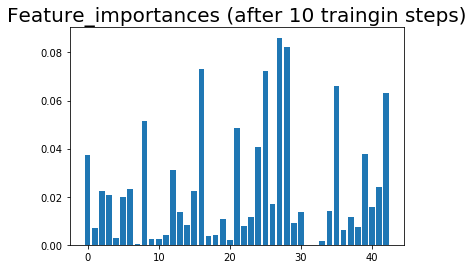

Text(0.5, 1.0, 'Feature_importances (after 50 traingin steps)')

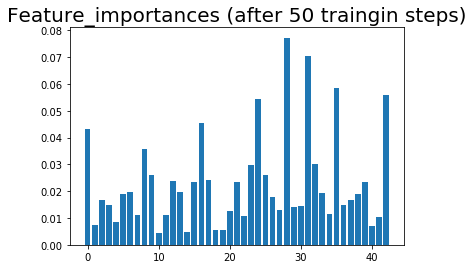

In [132]:
plt.bar(range(len(feat_dict_10)),list(feat_dict_10.values()))
plt.title("Feature_importances (after 10 traingin steps)", fontsize=20)
plt.show()
plt.bar(range(len(feat_dict_50)),list(feat_dict_50.values()))
plt.title("Feature_importances (after 50 traingin steps)", fontsize=20)

Text(0.5, 1.0, 'Feature_importances_weight')

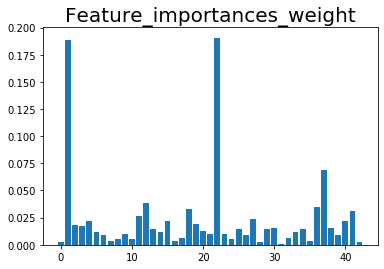

In [133]:
plt.bar(range(len(feat_weight_dict)),list(feat_weight_dict.values()))
plt.title("Feature_importances_weight", fontsize=20)

In [134]:
import pandas as pd




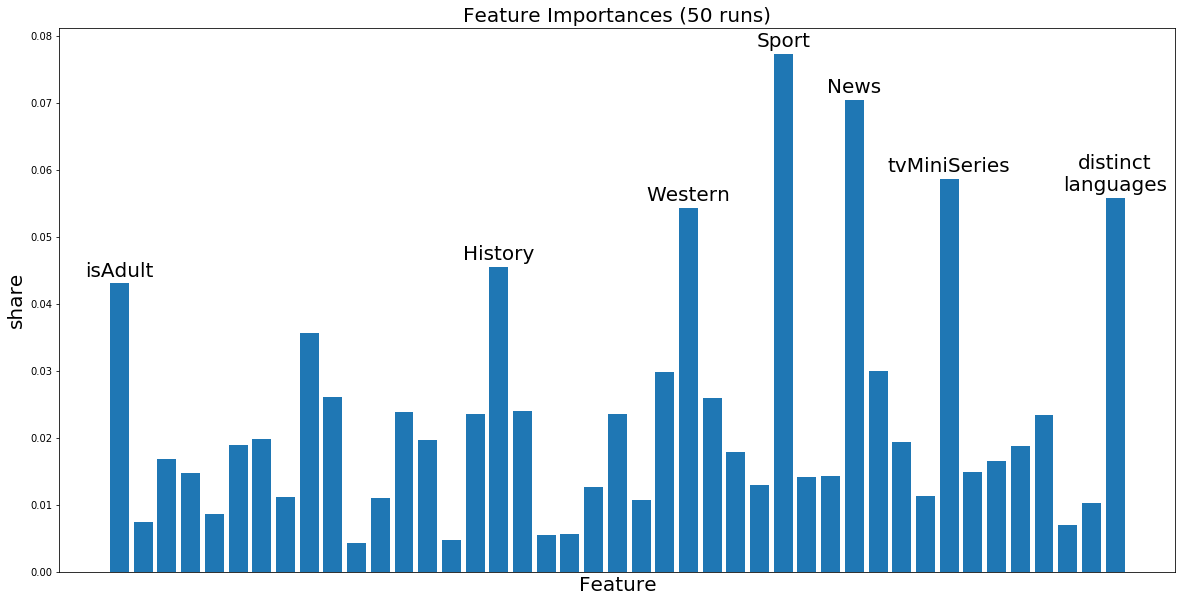

<Figure size 432x288 with 0 Axes>

In [138]:
from datetime import datetime

now = datetime.now() # current date and time
time = now.strftime("%m-%d-%Y-%H-%M-%S")
#print(time)

dict = feat_dict_50

fig,ax = plt.subplots(figsize=(20,10))

#pd.DataFrame(feat_dict, index=['quantity']).plot(kind='bar',ax=ax,use_index=False, legend=False,width=1.4)
plt.bar(*zip(*dict.items()))
plt.title('Feature Importances (50 runs)', fontsize=20)
plt.xlabel('Feature', fontsize=20)
plt.ylabel('share', fontsize=20)
plt.xticks(ticks=[])
threshold=0.038
pad=0.001
i=0
for k,v in dict.items():
    if v > threshold:
        ax.text(i,v+pad,k.replace(" ","\n"),horizontalalignment='center',fontsize=20)
    #reak
    i +=1
#plt.xlim([0,10])
#plt.ylim([0,10])
#plt.plot([0,10],[0,10], c='red')

plt.show()
save_it=True
if save_it == True:
    filename='Feature_importance_1-'+time
    plt.savefig(filename, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait')

In [89]:
for k,v in feat_dict.items():
    print(k,v)
    break

isAdult 0.051870616709514795


# Deploy Model

## Deploy

In [76]:
# Deploy  model to an endpoint

xgb_predictor = xgboost.deploy(
    initial_instance_count = 1, 
    instance_type = 'ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-----------------!

## Configure Predictor

In [77]:
# Configure the predictor's serializer and deserializer

# INSERT CODE HERE

from sagemaker.predictor import csv_serializer, json_deserializer

xgb_predictor.content_type = "text/csv"
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = json_deserializer

# Display Endpoint

In [78]:
xgb_predictor.endpoint

'JPC-xgboost-2020-11-18-14-16-01-550'

# Prediction

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000


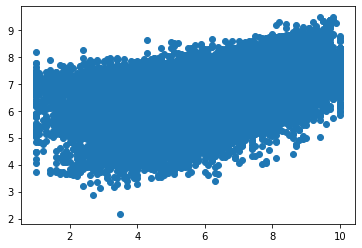

In [80]:
# carefully just one prediction
import pandas as pd
import matplotlib.pyplot as plt

col_names = ['averageRating', 'isAdult', 'startYear', 'endYear', 'numVotes', 'Crime', 'Romance', 'Thriller', 'Adventure', 'Drama', 'War', 'Documentary', 'Reality-TV', 'Family', 'Fantasy', 'Game-Show', 'Adult', 'History', 'Mystery', 'Musical', 'Animation', 'Music', 'Film-Noir', 'shortGenre', 'Horror', 'Western', 'Biography', 'Comedy', 'Action', 'Sport', 'Talk-Show', 'Sci-Fi', 'News', 'movie', 'short', 'tvEpisode', 'tvMiniSeries', 'tvMovie', 'tvSeries', 'tvShort', 'tvSpecial', 'video', 'videoGame', 'distinct languages', 'distinct regions']
test = pd.read_csv(f"{s3_path}{test_source_path}/{test_source_name}", header=0, index_col=False, names=col_names)
prediction=[]
for i in range(test.shape[0]):
    prediction.append(xgb_predictor.predict(test.iloc[i, 1:]))
    if i % 1000 == 0:
        print(i)
    #     print(prediction)
    #     print(test.iloc[i,0])
#print(prediction) 

plt.scatter(test.iloc[:,0], prediction)


11-18-2020-14-56-36


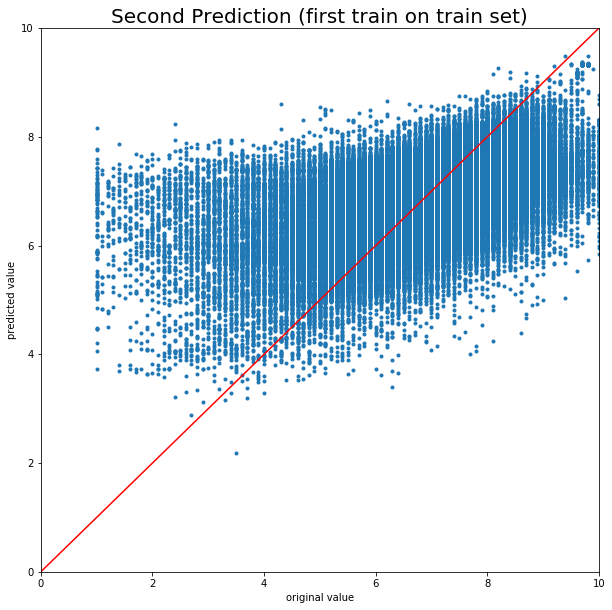

In [88]:
from datetime import datetime

now = datetime.now() # current date and time
time = now.strftime("%m-%d-%Y-%H-%M-%S")
print(time)



fig = plt.subplots(figsize=(10,10))
plt.scatter(test.iloc[:,0], prediction,marker='.')
plt.title('Second Prediction (first train on train set)', fontsize=20)
plt.xlabel('original value')
plt.ylabel('predicted value')
plt.xlim([0,10])
plt.ylim([0,10])
plt.plot([0,10],[0,10], c='red')

#plt.show()
filename='Prediction-'+time
plt.savefig(filename, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait')


11-18-2020-14-55-10
